In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import pickle

# load the climate data

In [3]:
import os
import pandas as pd
from tqdm import tqdm

root_path = r"D:\OneDrive - University of Edinburgh\paper\Spatio-temporal RSV\TAP-RSV 2\RSV\\"
csv_files = os.listdir(os.path.join(root_path, 'climate/'))[::-1]

def get_mean_precip(L):
    new_L = []
    for i in L:
        if i not in ["M", 'T']:
            new_L.append(eval(i))
    if len(new_L) > 0:
        return np.mean(new_L)
    else:
        return 0

def get_mean_temp(L):
    new_L = []
    for h, l in L.values:
        if (h not in ["M", 'T']) and (l not in ["M", "T"]):
            new_L.append((int(h) + int(l)) / 2)
    if len(new_L) > 0:
        return np.mean(new_L)
    else:
        return 0

precip = []
temp = []
for path in tqdm(csv_files):
    file = pd.read_csv(os.path.join(root_path, 'climate', path), index_col=False)
    precip.append(file.groupby(["state", "valid"])['precip_month'].\
                  apply(lambda x: get_mean_precip(x.values)).reset_index(name='mean_precip'))
    temp.append(file.groupby(["state", "valid"])[["high", "low"]].\
                  apply(lambda x: get_mean_temp(x)).reset_index(name='mean_temp'))

100%|██████████| 1869/1869 [00:24<00:00, 77.64it/s]


In [4]:
precip = pd.concat(precip)
temp = pd.concat(temp)

def clean_seq(obj):
    result = {}
    for mp, date in obj.values:
        result[date] = mp
    return result

precip_data = precip.groupby("state")["mean_precip", "valid"].apply(lambda x: clean_seq(x)).reset_index(name='prep_dict')
temp_data = temp.groupby("state")["mean_temp", "valid"].apply(lambda x: clean_seq(x)).reset_index(name='temp_dict')


C:\Users\Junyi\AppData\Local\Temp\ipykernel_29624\2555394956.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  precip_data = precip.groupby("state")["mean_precip", "valid"].apply(lambda x: clean_seq(x)).reset_index(name='prep_dict')
C:\Users\Junyi\AppData\Local\Temp\ipykernel_29624\2555394956.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_data = temp.groupby("state")["mean_temp", "valid"].apply(lambda x: clean_seq(x)).reset_index(name='temp_dict')


# load IQVIA data

In [5]:
bron = pickle.load(open(os.path.join(root_path, "data/bron.pkl"), 'rb'))
iqvia_dates = pickle.load(open(os.path.join(root_path, "data/weeks.pkl"), 'rb'))
fips2name = pickle.load(open(os.path.join(root_path, "data/fips2name.pkl"), 'rb'))
fips = pickle.load(open(os.path.join(root_path, "data/fips.pkl"), 'rb'))
bron= bron[:, :-6, 11]
iqvia_dates = iqvia_dates[:-6]

states = set(precip_data.state.tolist()).intersection(set(temp_data.state.tolist()))

ab2full = {'AL': 'Alabama',
            'AK': 'Alaska',
            'AZ': 'Arizona',
            'AR': 'Arkansas',
            'CA': 'California',
            'CO': 'Colorado',
            'CT': 'Connecticut',
            'DE': 'Delaware',
            'FL': 'Florida',
            'GA': 'Georgia',
            'HI': 'Hawaii',
            'ID': 'Idaho',
            'IL': 'Illinois',
            'IN': 'Indiana',
            'IA': 'Iowa',
            'KS': 'Kansas',
            'KY': 'Kentucky',
            'LA': 'Louisiana',
            'ME': 'Maine',
            'MD': 'Maryland',
            'MA': 'Massachusetts',
            'MI': 'Michigan',
            'MN': 'Minnesota',
            'MS': 'Mississippi',
            'MO': 'Missouri',
            'MT': 'Montana',
            'NE': 'Nebraska',
            'NV': 'Nevada',
            'NH': 'New Hampshire',
            'NJ': 'New Jersey',
            'NM': 'New Mexico',
            'NY': 'New York',
            'NC': 'North Carolina',
            'ND': 'North Dakota',
            'OH': 'Ohio',
            'OK': 'Oklahoma',
            'OR': 'Oregon',
            'PA': 'Pennsylvania',
            'RI': 'Rhode Island',
            'SC': 'South Carolina',
            'SD': 'South Dakota',
            'TN': 'Tennessee',
            'TX': 'Texas',
            'UT': 'Utah',
            'VT': 'Vermont',
            'VA': 'Virginia',
            'WA': 'Washington',
            'WV': 'West Virginia',
            'WI': 'Wisconsin',
            'WY': 'Wyoming',
            'DC': 'District of Columbia',
            'MP': 'Northern Mariana Islands',
            'PW': 'Palau',
            'PR': 'Puerto Rico',
            'VI': 'Virgin Islands',
            'AA': 'Armed Forces Americas (Except Canada)',
            'AE': 'Armed Forces Africa/Canada/Europe/Middle East',
            'AP': 'Armed Forces Pacific'}

iqvia = []
iqvia_state = []

for state in states:
    cur = []
    if state not in ab2full: continue
    full_state_name = ab2full[state]
    for idx, f in enumerate(fips):
        if fips2name[f].split(', ')[1] == full_state_name:
            cur.append(bron[idx])
    if len(cur) == 0:
        pass
    else:
        iqvia_state.append(state)
        iqvia.append(np.array(cur).sum(0).reshape(1, -1))
iqvia = np.concatenate(iqvia, 0)

print (iqvia.shape)
print (len(iqvia_dates))

(51, 258)
258


# align the IQVIA data with climate data

In [6]:
prep_stat = []
temp_stat = []
state_stat = []
state_name = []
    
for idx, state in enumerate(iqvia_state):
    try:
        prep_dict = precip_data[precip_data.state == state]["prep_dict"].values[0]
        cur = []
        for path in csv_files:
            date = path[:-4]
            if (date >= "2017-12-30") and (date <= "2022-12-17"):
                cur.append(prep_dict.get(date, 0))
        prep_stat.append(cur)

        temp_dict = temp_data[temp_data.state == state]["temp_dict"].values[0]
        cur = []
        for path in csv_files:
            date = path[:-4]
            if (date >= "2017-12-30") and (date <= "2022-12-17"):
                cur.append(temp_dict.get(date, 0))
        temp_stat.append(cur)
        state_name.append(state)
    except:
        print (f"{state} data is droped since it does not match")
#         prep_stat.append(np.array(prep_stat[-1].copy())*0)
#         temp_stat.append(np.array(temp_stat[-1].copy())*0)
#         state_stat.append(np.array(state_stat[-1].copy())*0)
#         state_name.append(state)

prep_stat = np.array(prep_stat)
prep_stat = np.diff(np.concatenate([np.zeros((prep_stat.shape[0], 1)), np.cumsum(prep_stat, 1)], 1)[:, ::7], axis=1)

temp_stat = np.array(temp_stat)
temp_stat = temp_stat[:, ::7][:, :-1]

In [7]:
print (prep_stat.shape)
print (temp_stat.shape)
print (iqvia.shape)

(51, 258)
(51, 258)
(51, 258)


# some random convolution correlation test

0.5144408525123304 231
0.34926189862638884 232
0.5135757952455208 231
0.497486453118236 234
0.5267419859758956 235
0.5998820460071841 228
0.5435854217181951 237
0.38726947844201637 233
0.44379744878508987 234
0.39208578168905456 227


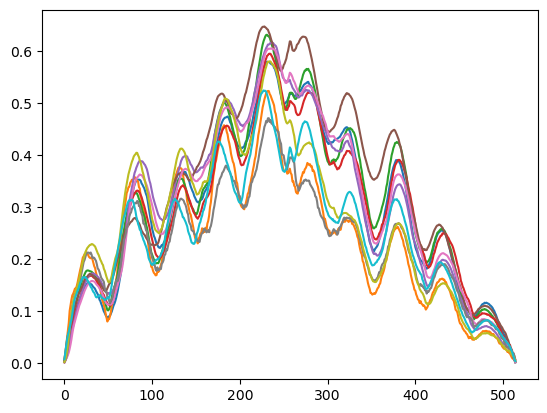

In [8]:
# correlation to temperature
for i in range(10):
    cov = np.convolve(temp_stat[i], iqvia[i][::-1]) / \
             np.sqrt(np.sum(temp_stat[i]**2)) / np.sqrt(np.sum(iqvia[i]**2))
    cov = cov
    plt.plot(cov)
    print (cov[261], np.argmax(cov))

0.41034977579944715 286
0.29522699138954217 227
0.45548227549781695 229
0.4515201337773641 277
0.39100502618135985 230
0.29345079697830306 120
0.5080009940343533 255
0.3737026394049628 257
0.4127592536770317 242
0.3942511108702226 256


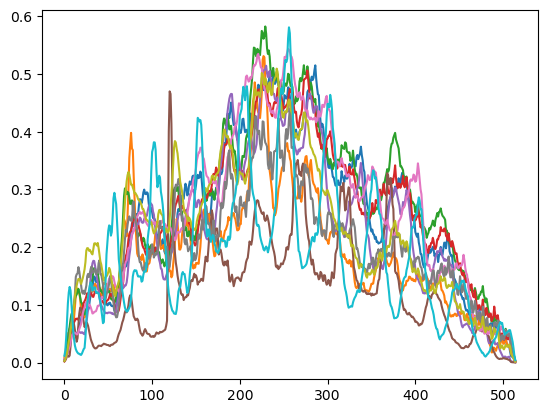

In [9]:
# correlation to precipitation
for i in range(10):
    cov = np.convolve(prep_stat[i], iqvia[i][::-1]) / \
             np.sqrt(np.sum(prep_stat[i]**2)) / np.sqrt(np.sum(iqvia[i]**2))
    cov = cov
    plt.plot(cov)
    
    print (cov[261], np.argmax(cov))

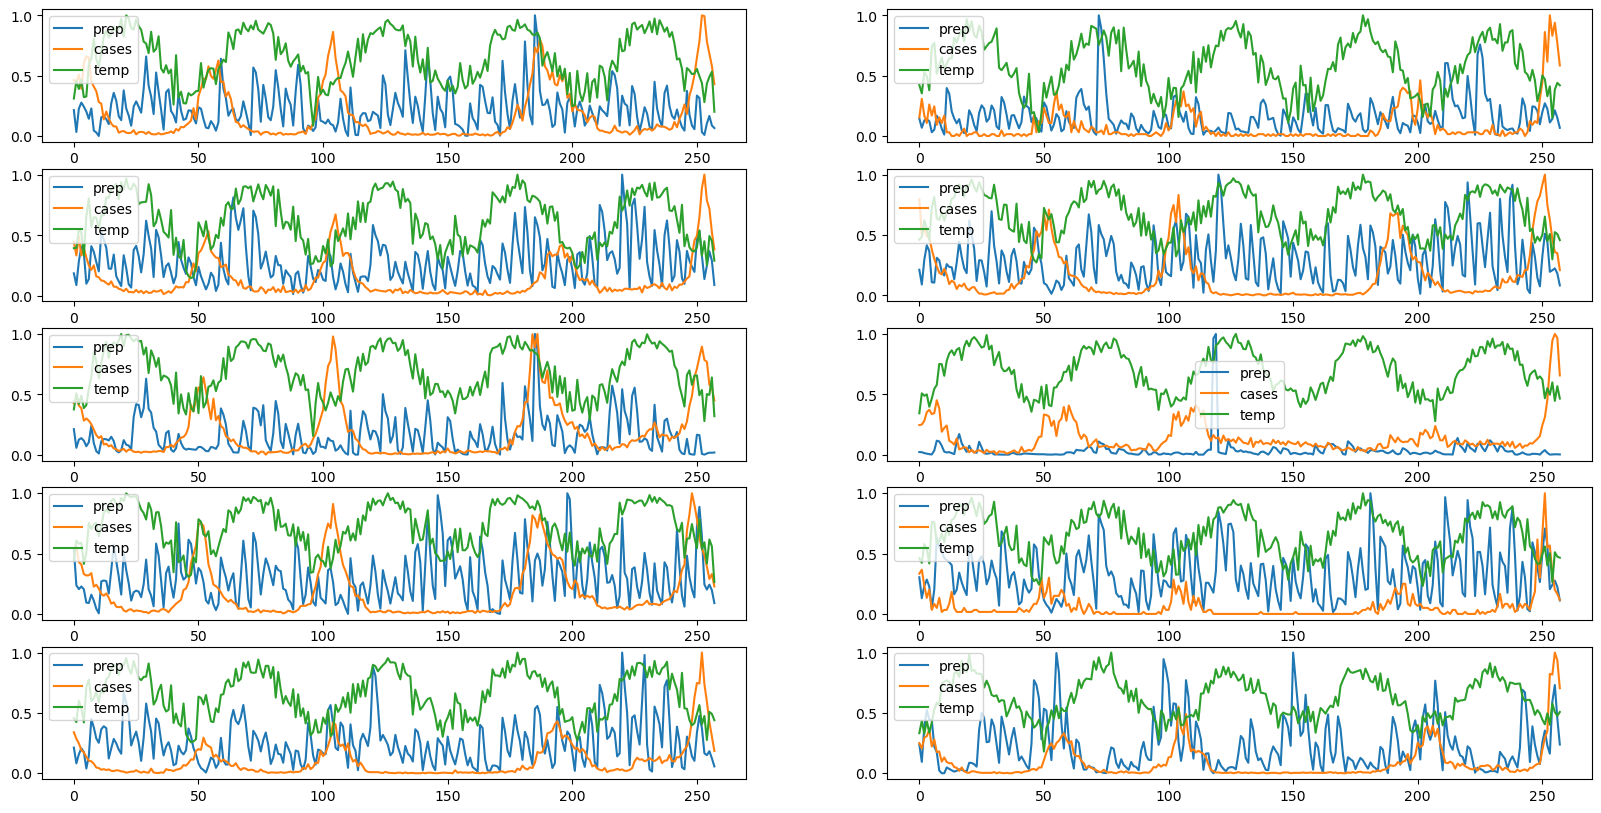

In [10]:
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(5,  2, i+1)
    plt.plot(prep_stat[i] / max(prep_stat[i]), label='prep')
    plt.plot(iqvia[i] / max(iqvia[i]), label='cases')
    plt.plot(temp_stat[i] / max(temp_stat[i]), label='temp')
    plt.legend()

# whether the volume of precipitation matters?

22 75
R² = 0.55
75 127
R² = 0.41
179 231
R² = 0.39
231 257
R² = 0.55


C:\Users\Junyi\AppData\Local\Temp\ipykernel_29624\2789074381.py:131: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


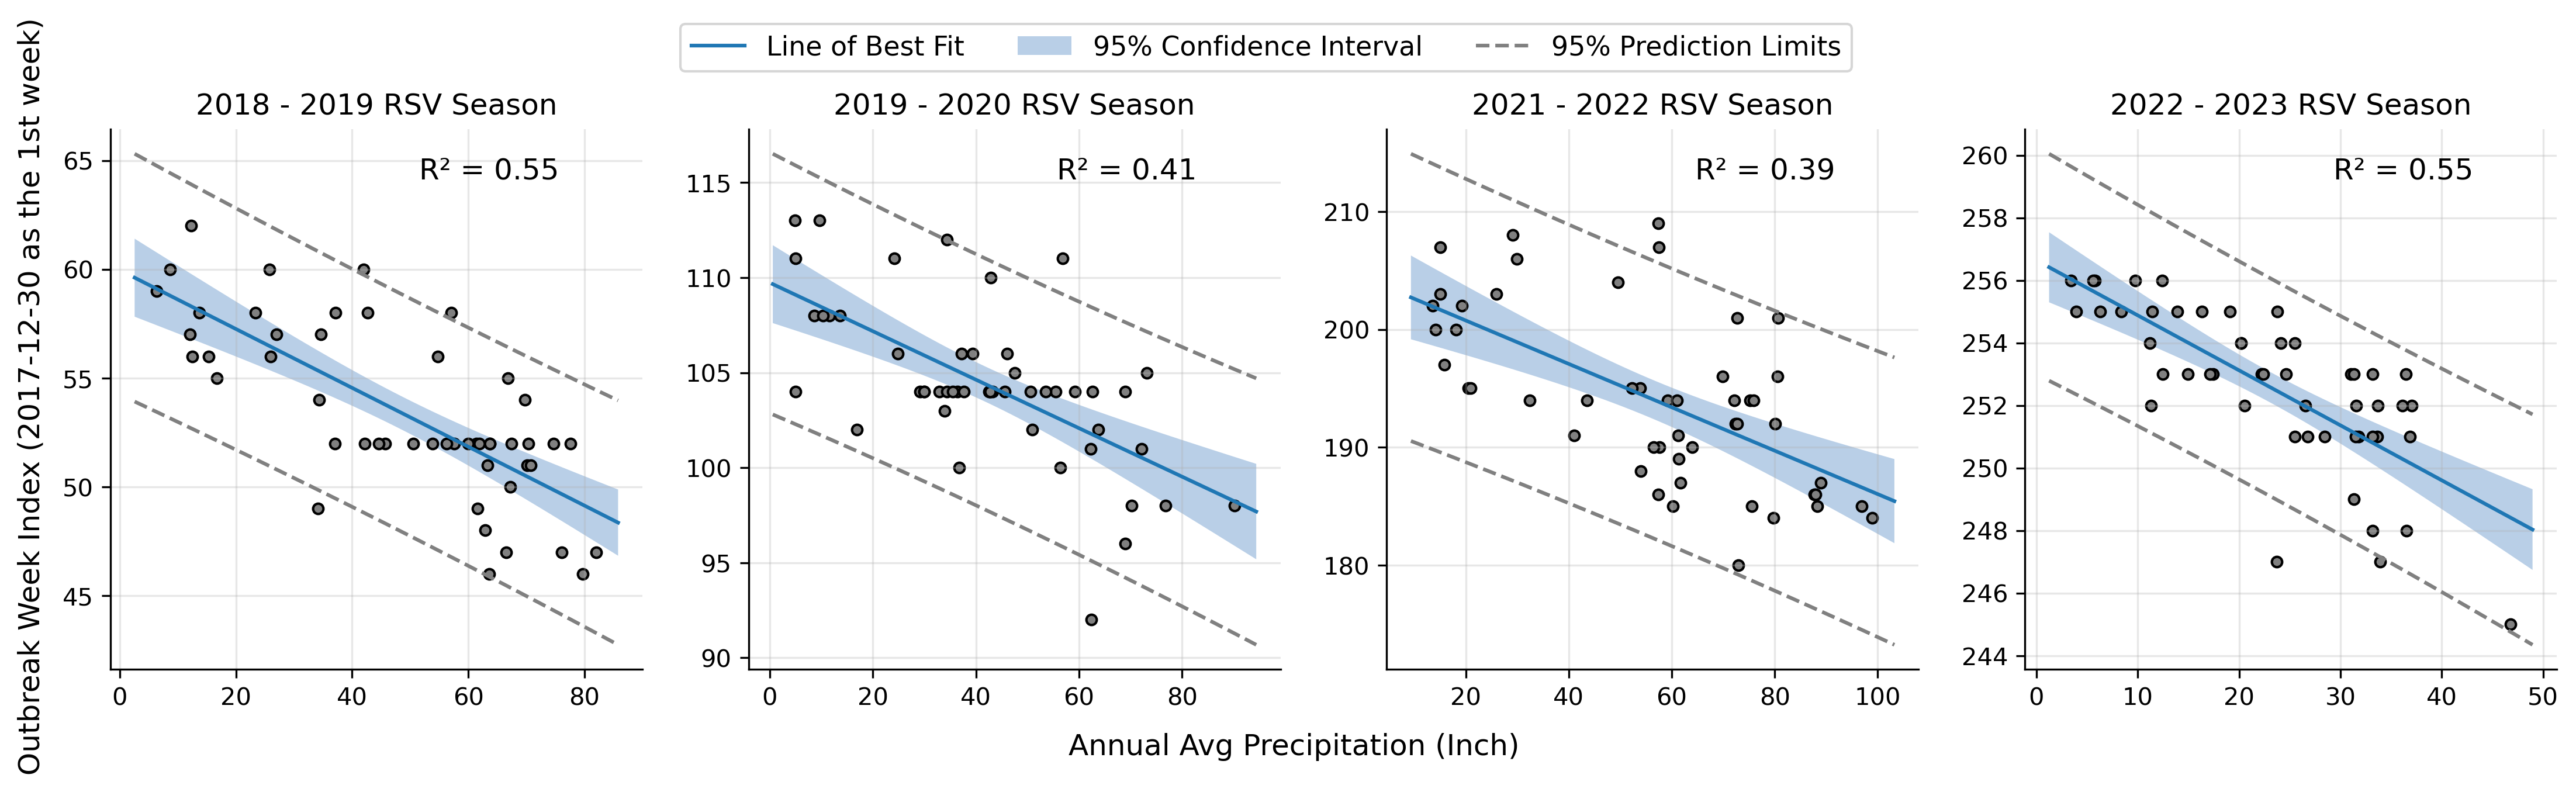

In [27]:
from scipy import stats

# get the volume
fig = plt.figure(figsize=(18, 4), dpi=300)
dates = iqvia_dates

def scatter_and_fit(x, y, title, ax, deg=1):
    x = np.array(x)
    y = np.array(y)
    
    # Parameters from the fit of the polynomia
    p = np.polyfit(x, y, deg)
    m = p[0]  # Gradient
    c = p[1]  # y-intercept

    # Number of observations
    n = y.size
    # Number of parameters: equal to the degree of the fitted polynomial (ie the
    # number of coefficients) plus 1 (ie the number of constants)
    m = p.size
    # Degrees of freedom (number of observations - number of parameters)
    dof = n - m
    # Significance level
    alpha = 0.05
    # We're using a two-sided test
    tails = 2
    # The percent-point function (aka the quantile function) of the t-distribution
    # gives you the critical t-value that must be met in order to get significance
    t_critical = stats.t.ppf(1 - (alpha / tails), dof)
    
    # Model the data using the parameters of the fitted straight line
    y_model = np.polyval(p, x)

    # Create the linear (1 degree polynomial) model
    model = np.poly1d(p)
    # Fit the model
    y_model = model(x)
    
    y_bar = np.mean(y)
    # Coefficient of determination, R²
    R2 = np.sum((y_model - y_bar)**2) / np.sum((y - y_bar)**2)

    print(f'R² = {R2:.2f}')
    
    # Calculate the residuals (the error in the data, according to the model)
    resid = y - y_model
    # Chi-squared (estimates the error in data)
    chi2 = sum((resid / y_model)**2)
    # Reduced chi-squared (measures the goodness-of-fit)
    chi2_red = chi2 / dof
    # Standard deviation of the error
    std_err = np.sqrt(sum(resid**2) / dof)
    
    ax.scatter(x, y, c='gray', marker='o', edgecolors='k', s=18)
    xlim = plt.xlim()
    ylim = plt.ylim()
    # Line of best fit
    ax.plot(np.array(xlim), p[1] + p[0] * np.array(xlim), label=f'Line of Best Fit')
    # Fit
    x_fitted = np.linspace(xlim[0], xlim[1], 100)
    y_fitted = np.polyval(p, x_fitted)
    # Confidence interval
    ci = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(
        x_fitted, y_fitted + ci, y_fitted - ci, facecolor='#b9cfe7', zorder=0,
        label=r'95% Confidence Interval'
    )
    # Prediction Interval
    pi = t_critical * std_err * np.sqrt(1 + 1 / n + (x_fitted - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.plot(x_fitted, y_fitted - pi, '--', color='0.5', label=r'95% Prediction Limits')
    ax.plot(x_fitted, y_fitted + pi, '--', color='0.5')
    # Title and labels
    ax.set_title(title)
    ax.grid(alpha=.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.58, 0.95, f'R² = {R2:.2f}', transform=ax.transAxes, va='top', fontdict={'size': 12})
    # Finished
#     plt.xlim(xlim)
#     plt.ylim(0, ylim[1])

ax = plt.subplot(141)
volume_list = []
onset_week = []
start = dates.index('2018-06-02')
end = dates.index('2019-06-08')
print (start, end)
for i in range(50):
    volume_list.append(np.sum(prep_stat[i, start: end]) * 30 / 365)
    onset_week.append(np.argmax(iqvia[i, start: end])+start)
scatter_and_fit(volume_list, onset_week, "2018 - 2019 RSV Season", ax)

ax = plt.subplot(142)
volume_list = []
onset_week = []
start = dates.index('2019-06-08')
end = dates.index('2020-06-06')
print (start, end)
for i in range(50):
    volume_list.append(np.sum(prep_stat[i, start: end]) * 30 / 365)
    onset_week.append(np.argmax(iqvia[i, start: end])+start)
scatter_and_fit(volume_list, onset_week, "2019 - 2020 RSV Season", ax)

ax = plt.subplot(143)
volume_list = []
onset_week = []
start = dates.index('2021-06-05')
end = dates.index('2022-06-04')
print (start, end)
for i in range(50):
    volume_list.append(np.sum(prep_stat[i, start: end]) * 30 / 365)
    onset_week.append(np.argmax(iqvia[i, start: end])+start)
scatter_and_fit(volume_list, onset_week, "2021 - 2022 RSV Season", ax)

ax = plt.subplot(144)
volume_list = []
onset_week = []
start = dates.index('2022-06-04')
end = 257
print (start, end)
for i in range(50):
    volume_list.append(np.sum(prep_stat[i, start: end]) * 30 / 365)
    onset_week.append(np.argmax(iqvia[i, start: end])+start)
scatter_and_fit(volume_list, onset_week, "2022 - 2023 RSV Season", ax)

ax.legend(fontsize=11, bbox_to_anchor=(-0.3,1.22), ncol=3)
#fig.text('Annual Avg Precipitation (Inch)')
#ax.set_ylabel("Onset Week Index (2017-12-30 as the 1st week)")
fig.text(0.5, 0, 'Annual Avg Precipitation (Inch)', ha='center', va='center', fontsize=12)
fig.text(0.1, 0.5, 'Outbreak Week Index (2017-12-30 as the 1st week)', ha='center', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()
#plt.subplots_adjust(wspace=0.3)
plt.savefig('../fig/rsv_onset_vs_precipitation.png', dpi=300, bbox_inches='tight')
plt.show()


# whether the annual temperature matters?

22 75
R² = 0.14
75 127
R² = 0.45
179 231
R² = 0.18
231 257
R² = 0.33


C:\Users\Junyi\AppData\Local\Temp\ipykernel_29624\2193898075.py:131: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


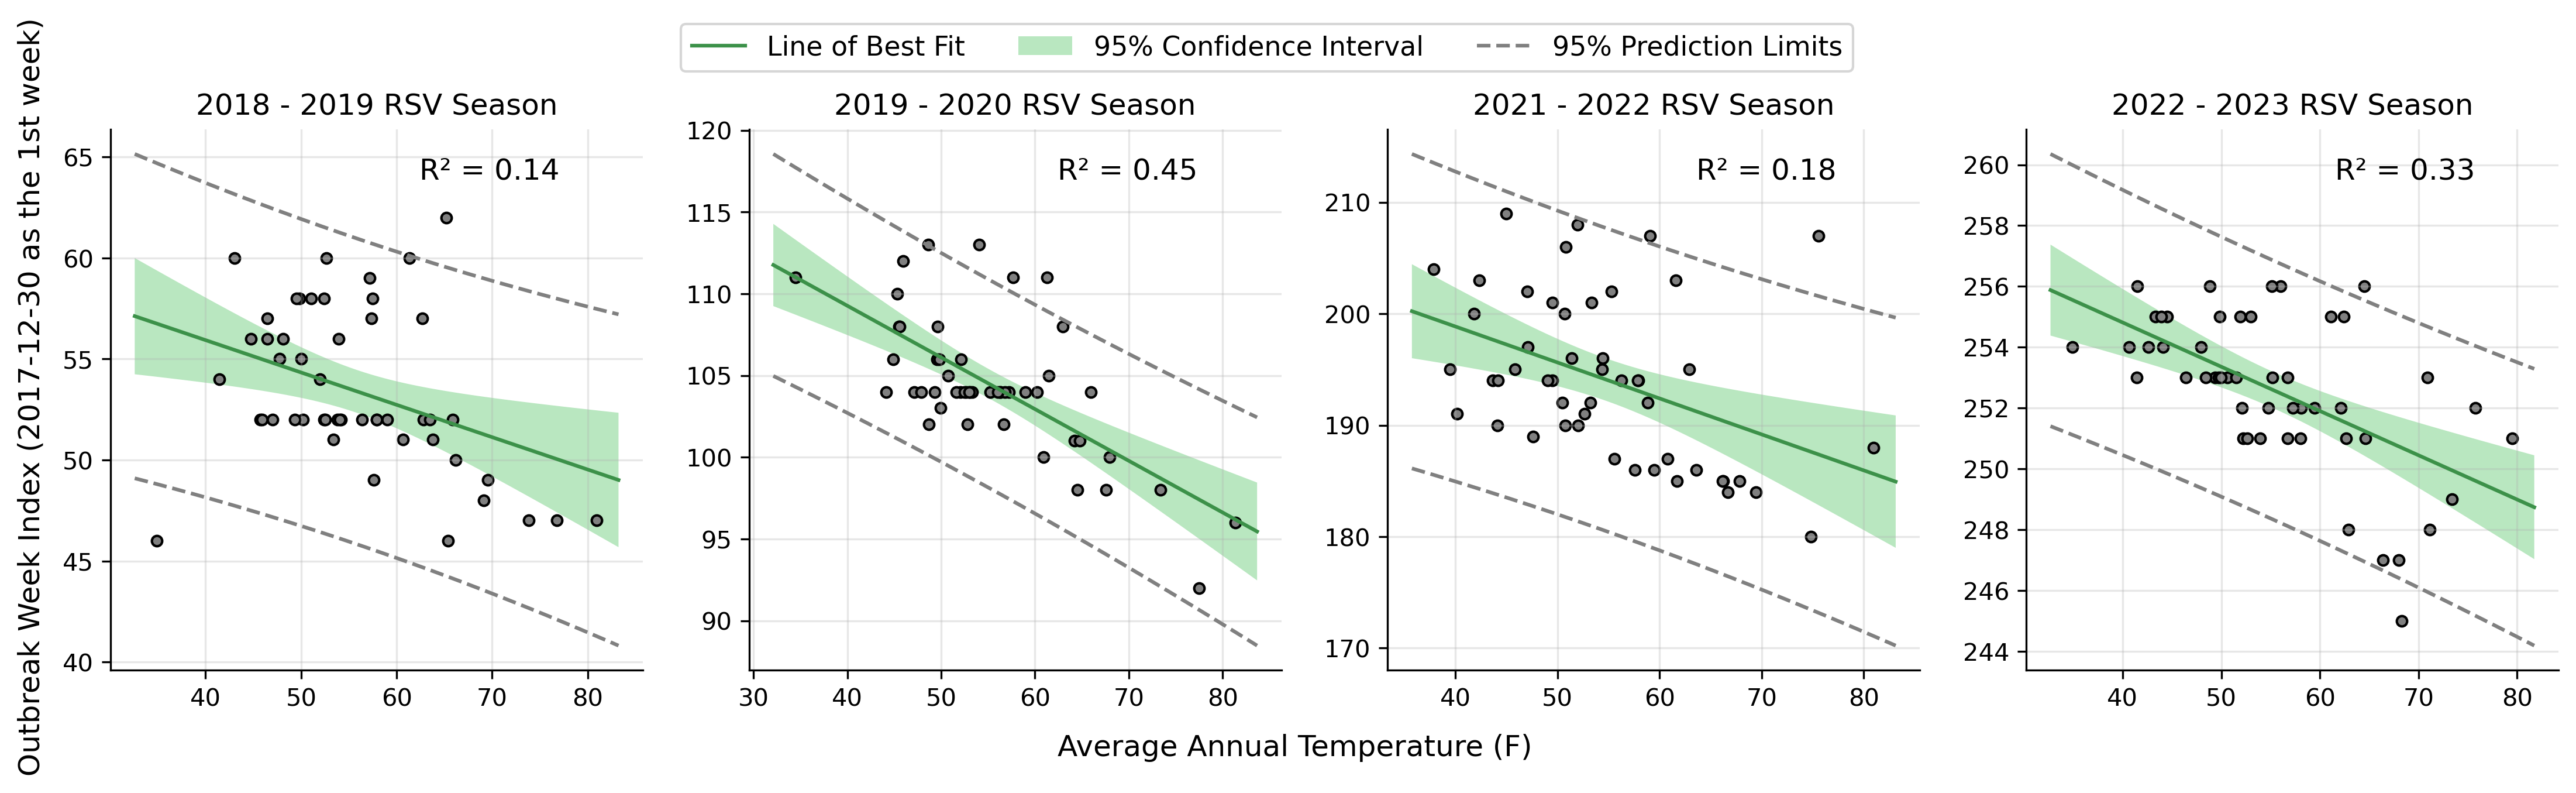

In [24]:
from scipy import stats

# get the volume
fig = plt.figure(figsize=(18, 4), dpi=300)
dates = iqvia_dates

def scatter_and_fit(x, y, title, ax, deg=1):
    x = np.array(x)
    y = np.array(y)
    
    # Parameters from the fit of the polynomia
    p = np.polyfit(x, y, deg)
    m = p[0]  # Gradient
    c = p[1]  # y-intercept

    # Number of observations
    n = y.size
    # Number of parameters: equal to the degree of the fitted polynomial (ie the
    # number of coefficients) plus 1 (ie the number of constants)
    m = p.size
    # Degrees of freedom (number of observations - number of parameters)
    dof = n - m
    # Significance level
    alpha = 0.05
    # We're using a two-sided test
    tails = 2
    # The percent-point function (aka the quantile function) of the t-distribution
    # gives you the critical t-value that must be met in order to get significance
    t_critical = stats.t.ppf(1 - (alpha / tails), dof)
    
    # Model the data using the parameters of the fitted straight line
    y_model = np.polyval(p, x)

    # Create the linear (1 degree polynomial) model
    model = np.poly1d(p)
    # Fit the model
    y_model = model(x)
    
    y_bar = np.mean(y)
    # Coefficient of determination, R²
    R2 = np.sum((y_model - y_bar)**2) / np.sum((y - y_bar)**2)

    print(f'R² = {R2:.2f}')
    
    # Calculate the residuals (the error in the data, according to the model)
    resid = y - y_model
    # Chi-squared (estimates the error in data)
    chi2 = sum((resid / y_model)**2)
    # Reduced chi-squared (measures the goodness-of-fit)
    chi2_red = chi2 / dof
    # Standard deviation of the error
    std_err = np.sqrt(sum(resid**2) / dof)
    
    ax.scatter(x, y, c='gray', marker='o', edgecolors='k', s=18)
    xlim = plt.xlim()
    ylim = plt.ylim()
    # Line of best fit
    ax.plot(np.array(xlim), p[1] + p[0] * np.array(xlim), color="#3c9149", label=f'Line of Best Fit')
    # Fit
    x_fitted = np.linspace(xlim[0], xlim[1], 100)
    y_fitted = np.polyval(p, x_fitted)
    # Confidence interval
    ci = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(
        x_fitted, y_fitted + ci, y_fitted - ci, facecolor='#b9e7c0', zorder=0,
        label=r'95% Confidence Interval'
    )
    # Prediction Interval
    pi = t_critical * std_err * np.sqrt(1 + 1 / n + (x_fitted - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.plot(x_fitted, y_fitted - pi, '--', color='0.5', label=r'95% Prediction Limits')
    ax.plot(x_fitted, y_fitted + pi, '--', color='0.5')
    # Title and labels
    ax.set_title(title)
    
    ax.grid(alpha=.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.58, 0.95, f'R² = {R2:.2f}', transform=ax.transAxes, va='top', fontdict={'size': 12})
    # Finished
#     plt.xlim(xlim)
#     plt.ylim(0, ylim[1])

ax = plt.subplot(141)
volume_list = []
onset_week = []
start = dates.index('2018-06-02')
end = dates.index('2019-06-08')
print (start, end)
for i in range(50):
    volume_list.append(np.mean(temp_stat[i, start: end]))
    onset_week.append(np.argmax(iqvia[i, start: end])+start)
scatter_and_fit(volume_list, onset_week, "2018 - 2019 RSV Season", ax)

ax = plt.subplot(142)
volume_list = []
onset_week = []
start = dates.index('2019-06-08')
end = dates.index('2020-06-06')
print (start, end)
for i in range(50):
    volume_list.append(np.mean(temp_stat[i, start: end]))
    onset_week.append(np.argmax(iqvia[i, start: end])+start)
scatter_and_fit(volume_list, onset_week, "2019 - 2020 RSV Season", ax)

ax = plt.subplot(143)
volume_list = []
onset_week = []
start = dates.index('2021-06-05')
end = dates.index('2022-06-04')
print (start, end)
for i in range(50):
    volume_list.append(np.mean(temp_stat[i, start: end]))
    onset_week.append(np.argmax(iqvia[i, start: end])+start)
scatter_and_fit(volume_list, onset_week, "2021 - 2022 RSV Season", ax)

ax = plt.subplot(144)
volume_list = []
onset_week = []
start = dates.index('2022-06-04')
end = 257
print (start, end)
for i in range(50):
    volume_list.append(np.mean(temp_stat[i, start: end]))
    onset_week.append(np.argmax(iqvia[i, start: end])+start)
scatter_and_fit(volume_list, onset_week, "2022 - 2023 RSV Season", ax)
ax.legend(fontsize=11, bbox_to_anchor=(-0.3,1.22), ncol=3)
#fig.text('Annual Avg Precipitation (Inch)')
#ax.set_ylabel("Onset Week Index (2017-12-30 as the 1st week)")
fig.text(0.5, 0, 'Average Annual Temperature (F)', ha='center', va='center', fontsize=12)
fig.text(0.1, 0.5, 'Outbreak Week Index (2017-12-30 as the 1st week)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig('../fig/rsv_onset_vs_temp.png', dpi=300, bbox_inches='tight')

In [14]:
def extract_lon_lat(x):
    return (x["lat"].mean(), x["lon"].mean())

lat_long_state = file[["state", "lat", "lon"]].groupby("state").apply(lambda x: \
                                                extract_lon_lat(x)).reset_index(name="lon_lat")

In [15]:
state_to_lon_lat = {state: lon_lat for state, lon_lat in lat_long_state.values}

22 75
ratio -0.2
R² = 0.16
75 127
ratio -0.1
R² = 0.42
179 231
ratio -0.35
R² = 0.37
231 257
ratio -0.25
R² = 0.36


C:\Users\Junyi\AppData\Local\Temp\ipykernel_29624\808815794.py:150: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


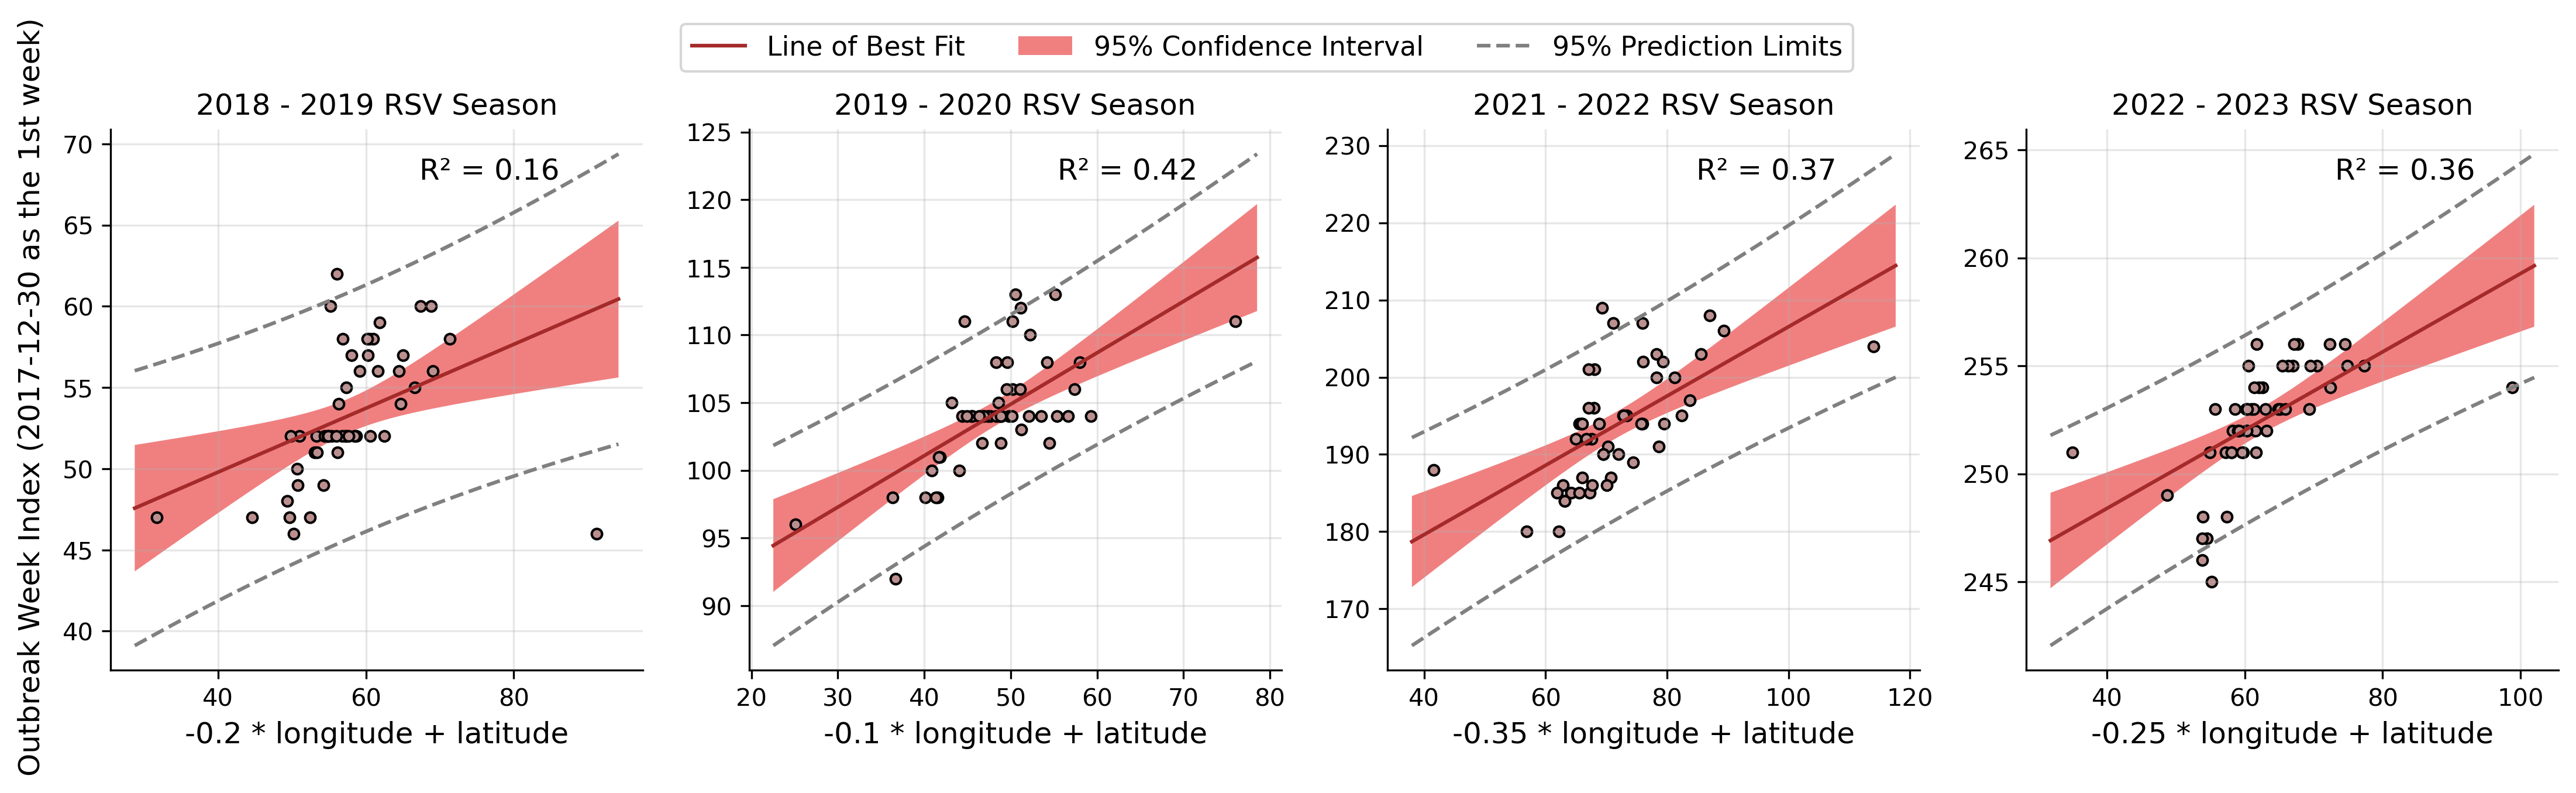

In [30]:
from scipy import stats

# get the volume
fig = plt.figure(figsize=(18, 4), dpi=300)
dates = iqvia_dates

def scatter_and_fit(x, y, title, xlabel, ax, deg=1):
    x = np.array(x)
    y = np.array(y)
    
    # Parameters from the fit of the polynomia
    p = np.polyfit(x, y, deg)
    m = p[0]  # Gradient
    c = p[1]  # y-intercept
    
    # Number of observations
    n = y.size
    # Number of parameters: equal to the degree of the fitted polynomial (ie the
    # number of coefficients) plus 1 (ie the number of constants)
    m = p.size
    # Degrees of freedom (number of observations - number of parameters)
    dof = n - m
    # Significance level
    alpha = 0.05
    # We're using a two-sided test
    tails = 2
    # The percent-point function (aka the quantile function) of the t-distribution
    # gives you the critical t-value that must be met in order to get significance
    t_critical = stats.t.ppf(1 - (alpha / tails), dof)
    
    # Model the data using the parameters of the fitted straight line
    y_model = np.polyval(p, x)

    # Create the linear (1 degree polynomial) model
    model = np.poly1d(p)
    # Fit the model
    y_model = model(x)
    
    y_bar = np.mean(y)
    # Coefficient of determination, R²
    R2 = np.sum((y_model - y_bar)**2) / np.sum((y - y_bar)**2)

    print(f'R² = {R2:.2f}')
    
    # Calculate the residuals (the error in the data, according to the model)
    resid = y - y_model
    # Chi-squared (estimates the error in data)
    chi2 = sum((resid / y_model)**2)
    # Reduced chi-squared (measures the goodness-of-fit)
    chi2_red = chi2 / dof
    # Standard deviation of the error
    std_err = np.sqrt(sum(resid**2) / dof)
    
    ax.scatter(x, y, c='rosybrown', marker='o', edgecolors='k', s=18)
    xlim = plt.xlim()
    ylim = plt.ylim()
    # Line of best fit
    ax.plot(np.array(xlim), p[1] + p[0] * np.array(xlim), color="brown", label=f'Line of Best Fit')
    # Fit
    x_fitted = np.linspace(xlim[0], xlim[1], 100)
    y_fitted = np.polyval(p, x_fitted)
    # Confidence interval
    ci = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(
        x_fitted, y_fitted + ci, y_fitted - ci, facecolor='lightcoral', zorder=0,
        label=r'95% Confidence Interval'
    )
    # Prediction Interval
    pi = t_critical * std_err * np.sqrt(1 + 1 / n + (x_fitted - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.plot(x_fitted, y_fitted - pi, '--', color='0.5', label=r'95% Prediction Limits')
    ax.plot(x_fitted, y_fitted + pi, '--', color='0.5')
    # Title and labels
    plt.title(title)
    ax.set_xlabel(xlabel, fontdict={'size': 12})
    # plt.ylabel("Outbreak Week Index (2017-12-30 as the 1st week)")
    # Finished
    #plt.legend(fontsize=8)
    
    ax.grid(alpha=.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.58, 0.95, f'R² = {R2:.2f}', transform=ax.transAxes, va='top', fontdict={'size': 12})
#     plt.xlim(xlim)
#     plt.ylim(0, ylim[1])

def agg(X, y):
    X = np.array(X)
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression().fit(X, y)
    ratio = reg.coef_[1] / reg.coef_[0]
    ratio = (np.round(ratio, 1) - 0.2) / 2
    print ("ratio", ratio)
    return X[:, 0] + X[:, 1] * ratio, ratio
    
ax = plt.subplot(141)
volume_list = []
onset_week = []
start = dates.index('2018-06-02')
end = dates.index('2019-06-08')
print (start, end)
for i in range(51):
    volume_list.append(state_to_lon_lat[state_name[i]])
    onset_week.append(np.argmax(iqvia[i, start: end])+start)

p, ratio = agg(volume_list, onset_week)
scatter_and_fit(p, onset_week, "2018 - 2019 RSV Season", f"{ratio} * longitude + latitude", ax)

ax = plt.subplot(142)
volume_list = []
onset_week = []
start = dates.index('2019-06-08')
end = dates.index('2020-06-06')
print (start, end)
for i in range(51):
    volume_list.append(state_to_lon_lat[state_name[i]])
    onset_week.append(np.argmax(iqvia[i, start: end])+start)

p, ratio = agg(volume_list, onset_week)
scatter_and_fit(p, onset_week, "2019 - 2020 RSV Season", f"{ratio} * longitude + latitude", ax)

ax = plt.subplot(143)
volume_list = []
onset_week = []
start = dates.index('2021-06-05')
end = dates.index('2022-06-04')
print (start, end)
for i in range(51):
    volume_list.append(state_to_lon_lat[state_name[i]])
    onset_week.append(np.argmax(iqvia[i, start: end])+start)

p, ratio = agg(volume_list, onset_week)
scatter_and_fit(p, onset_week, "2021 - 2022 RSV Season", f"{ratio} * longitude + latitude", ax)

ax = plt.subplot(144)
volume_list = []
onset_week = []
start = dates.index('2022-06-04')
end = 257
print (start, end)
for i in range(51):
    volume_list.append(state_to_lon_lat[state_name[i]])
    onset_week.append(np.argmax(iqvia[i, start: end])+start)

p, ratio = agg(volume_list, onset_week)
scatter_and_fit(p, onset_week, "2022 - 2023 RSV Season", f"{ratio} * longitude + latitude", ax)

ax.legend(fontsize=11, bbox_to_anchor=(-0.3,1.22), ncol=3)

fig.text(0.1, 0.5, 'Outbreak Week Index (2017-12-30 as the 1st week)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig('../fig/rsv_onset_vs_lat.png', dpi=300, bbox_inches='tight')